# Porto Seguro’s Safe Driver Prediction

I got Felipe Antunes code as a startpack: https://github.com/felipeeeantunes/udacity_live

## Initializing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import gc
from time import time
from multiprocessing import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
pd.options.display.float_format = '{:.2f}'.format
rc={'savefig.dpi': 75, 'figure.autolayout': False, 'figure.figsize': [12, 8], 'axes.labelsize': 18,\
   'axes.titlesize': 18, 'font.size': 18, 'lines.linewidth': 2.0, 'lines.markersize': 8, 'legend.fontsize': 16,\
   'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(style='dark',rc=rc)

In [3]:
default_color = '#56B4E9'
colormap = plt.cm.cool

In [4]:
# Setting working directory
path = '../data/raw/'

## Loading Files

In [13]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [14]:
y = train['target']
del train['target']

In [15]:
y.head(5)

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [16]:
id_train = train['id'].values
id_test = test['id'].values

In [61]:
columns_original = list(train.columns)
columns_original

['id',
 'ps_ind_01',
 'ps_ind_02_cat',
 'ps_ind_03',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15',
 'ps_calc_01',
 'ps_calc_02',
 'ps_calc_03',
 'ps_calc_04',
 'ps_calc_05',
 'ps_calc_06',
 'ps_calc_07',
 'ps_calc_08',
 'ps_calc_09',
 'ps_calc_10',
 'ps_calc_11',
 'ps_calc_12',
 'ps_calc_13',
 'ps_calc_14',
 'ps_calc_15_bin',
 'ps_calc_16_bin',
 'ps_calc_17_bin',
 'ps_calc_18_bin',
 'ps_calc_19_bin',
 'ps_calc_20_bin']

In [9]:
train.head(5)

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
1,9,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
2,13,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
3,16,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


### Transforming -1 'null's in np.NaN

In [37]:
train = train.replace(-1, np.NaN)
test = test.replace(-1, np.NaN)

## Target Analysis

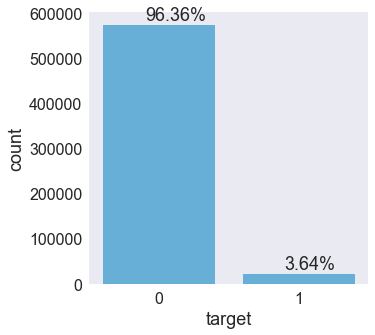

In [38]:
plt.figure(figsize=(5,5))

ax = sns.countplot(x=y, color=default_color)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(y)), (p.get_x()+ 0.3, p.get_height()+10000))

## Data Analysis

In [39]:
def get_meta(train):
    data = []
    for col in train.columns:
        # Defining the role
        if col == 'target':
            role = 'target'
        elif col == 'id':
            role = 'id'
        else:
            role = 'input'

        # Defining the level
        if 'bin' in col or col == 'target':
            level = 'binary'
        elif 'cat' in col or col == 'id':
            level = 'nominal'
        elif train[col].dtype == np.float64:
            level = 'interval'
        elif train[col].dtype == np.int64:
            level = 'ordinal'

        # Initialize keep to True for all variables except for id
        keep = True
        if col == 'id':
            keep = False

        # Defining the data type 
        dtype = train[col].dtype

        source = 'id'
        if '_ind_' in col:
            source = 'ind'
        if '_reg_' in col:
            source = 'reg'
        elif '_car_' in col:
            source = 'car'
        elif '_calc_' in col:
            source = 'calc'
        
        # Creating a Dict that contains all the metadata for the variable
        col_dict = {
            'varname': col,
            'role'   : role,
            'level'  : level,
            'keep'   : keep,
            'dtype'  : dtype,
            'source' : source
        }
        data.append(col_dict)
    meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype', 'source'])
    meta.set_index('varname', inplace=True)
    return meta
        

In [40]:
meta_data = get_meta(train)
meta_data

,role,level,keep,dtype,source
varname,,,,,
id,id,nominal,False,int64,id
ps_ind_01,input,ordinal,True,int64,ind
ps_ind_02_cat,input,nominal,True,float64,ind
ps_ind_03,input,ordinal,True,int64,ind
ps_ind_04_cat,input,nominal,True,float64,ind
ps_ind_05_cat,input,nominal,True,float64,ind
ps_ind_06_bin,input,binary,True,int64,ind
ps_ind_07_bin,input,binary,True,int64,ind
ps_ind_08_bin,input,binary,True,int64,ind


In [41]:
meta_counts = meta_data.groupby(['role', 'level']).agg({'dtype': lambda x: x.count()}).reset_index()
meta_counts

,role,level,dtype
0,id,nominal,1
1,input,binary,17
2,input,interval,11
3,input,nominal,14
4,input,ordinal,15


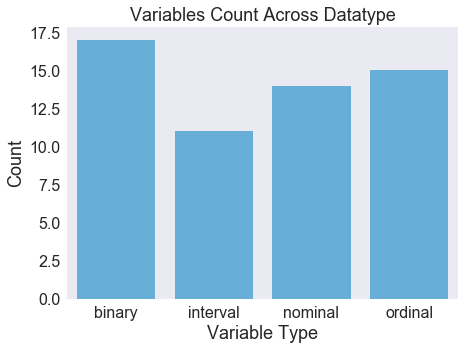

In [42]:
fig,ax = plt.subplots()
fig.set_size_inches(7,5)
sns.barplot(data=meta_counts[(meta_counts.role != 'target') & (meta_counts.role != 'id') ],x="level",y="dtype",ax=ax,color=default_color)
ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")

In [43]:
col_ordinal   = meta_data[(meta_data.level == 'ordinal') & (meta_data.keep)].index
col_nominal   = meta_data[(meta_data.level == 'nominal') & (meta_data.keep)].index
col_internval = meta_data[(meta_data.level == 'interval') & (meta_data.keep)].index
col_binary    = meta_data[(meta_data.level == 'binary') & (meta_data.keep) & (meta_data.role != 'target')].index

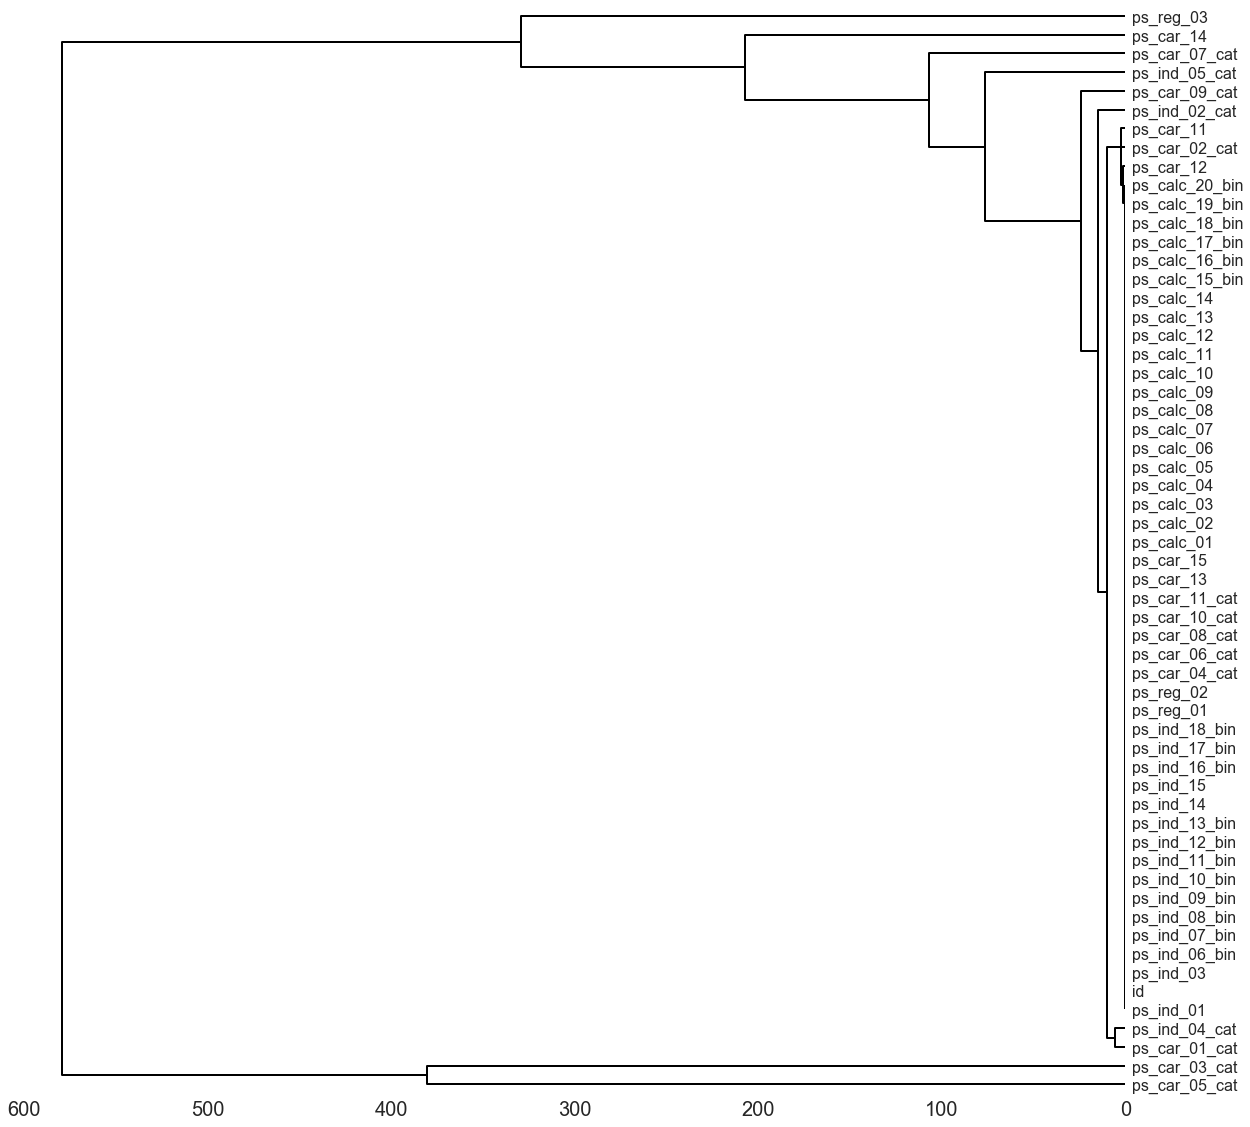

In [64]:
msno.dendrogram(train[columns_original],figsize=(20,20))

### Missing Values

In [44]:
missingValueColumns = train.columns[train.isnull().any()].tolist()
df_null = train[missingValueColumns]

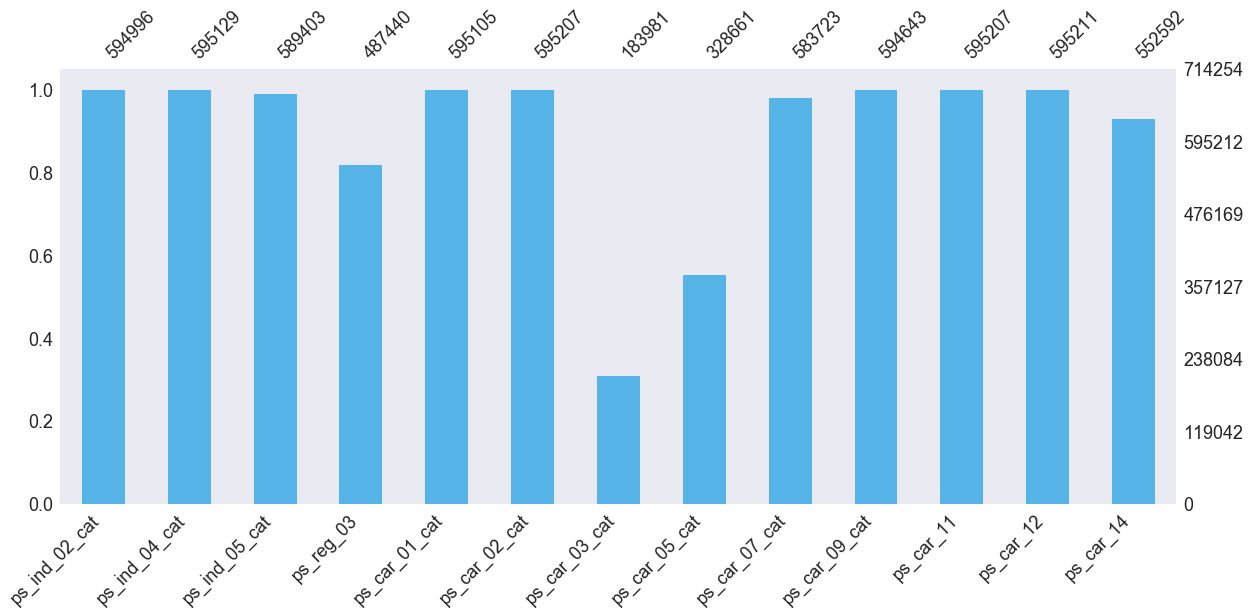

In [47]:
msno.bar(df_null,figsize=(20,8),color=default_color,fontsize=18,labels=True)

### Correlations between missing Values

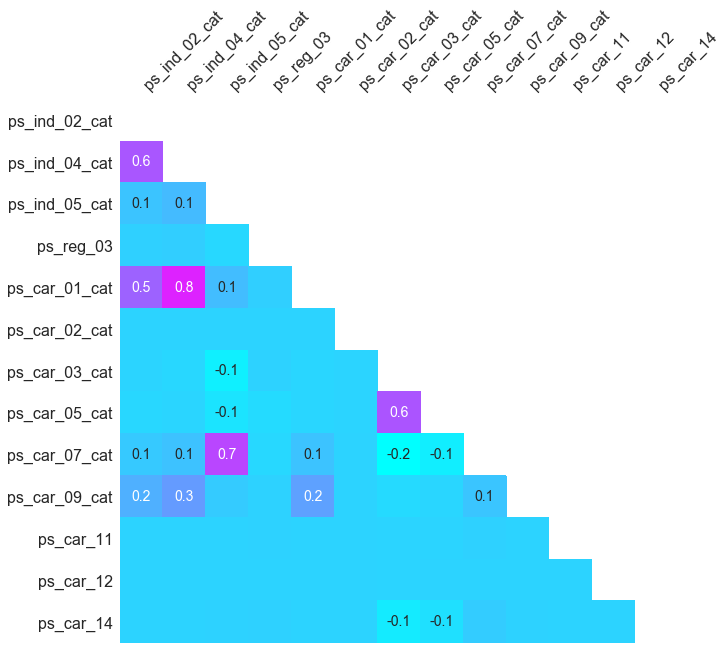

In [51]:
msno.heatmap(df_null,figsize=(10,10),cmap=colormap)

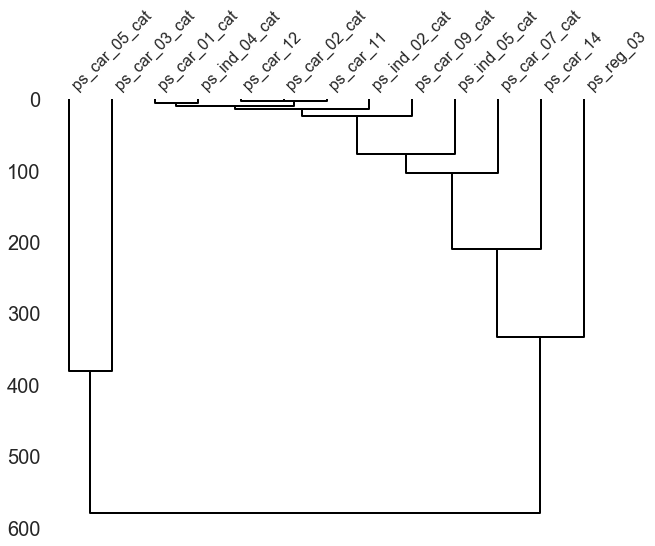

In [59]:
msno.dendrogram(df_null,figsize=(10,8))

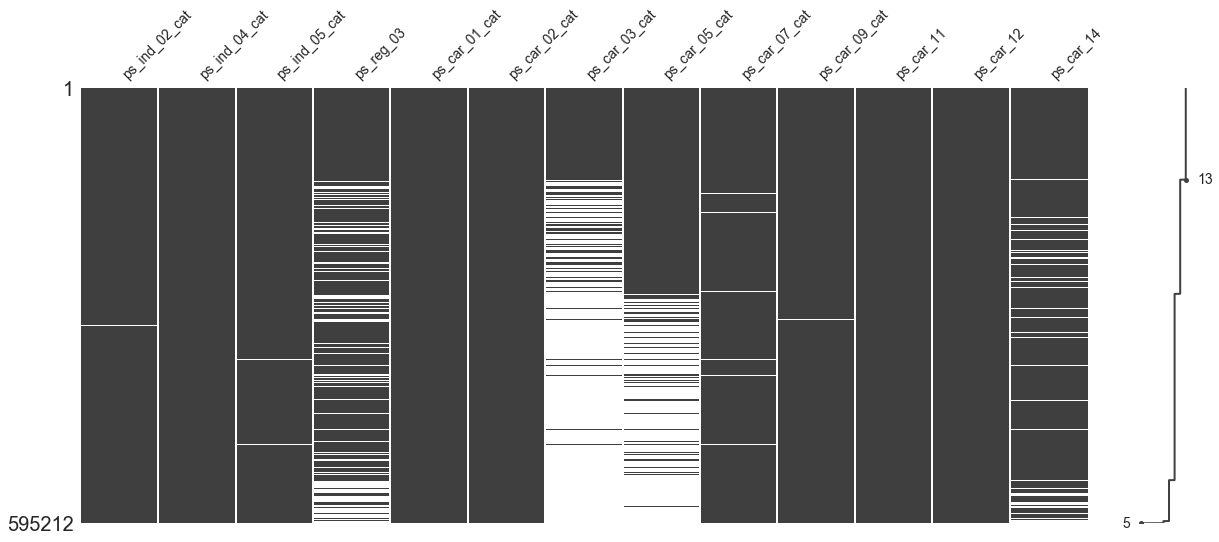

In [65]:
sorted_data = msno.nullity_sort(df_null, sort='descending') # or sort='ascending'
msno.matrix(sorted_data,figsize=(20,8),fontsize=14)

### Continuous Features Analysis

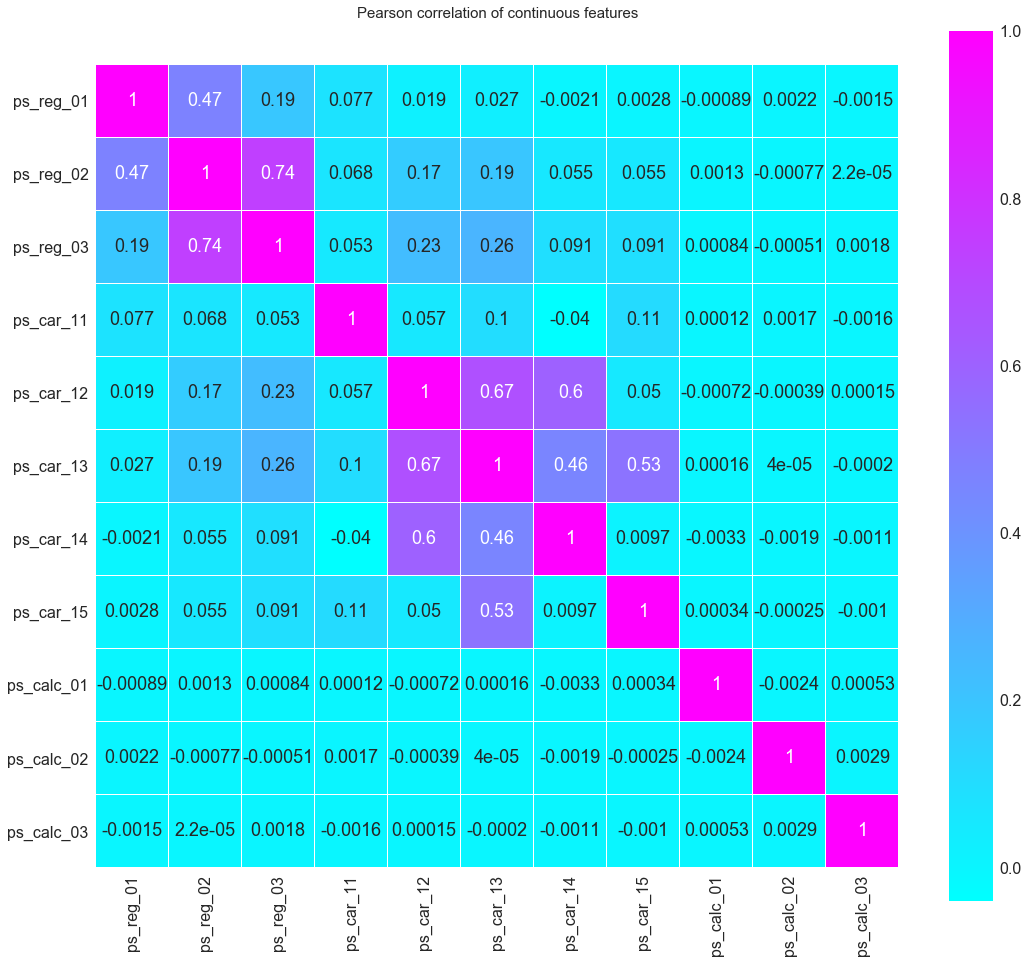

In [66]:
plt.figure(figsize=(18,16))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train[col_internval].corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

### Use -1 instead of NaN

In [123]:
train = train.fillna(-1)
test = test.fillna(-1)

### Simple Baseline RF Model and Feature Importance

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [100]:
conf_rf_featimp = {
    'n_estimators': 200,
    'max_depth': 6,
    'min_samples_leaf': 10,
    'max_features': 0.2,
    'n_jobs': -1,
    'random_state': 0
}

In [101]:
rf_featimp = RandomForestClassifier(**conf_rf_featimp)

In [106]:
t0 = time()
rf_featimp.fit(train, y)
print("----- Training Time: %  secs. -----" % (time()-t0))

----- Training Time: 125.28615856170654ecs. -----


In [107]:
features = columns_original

In [108]:
def get_feature_importance_df(feature_importances, 
                              column_names, 
                              top_n=25):
    """Get feature importance data frame.
 
    Parameters
    ----------
    feature_importances : numpy ndarray
        Feature importances computed by an ensemble 
            model like random forest or boosting
    column_names : array-like
        Names of the columns in the same order as feature 
            importances
    top_n : integer
        Number of top features
 
    Returns
    -------
    df : a Pandas data frame
 
    """
     
    imp_dict = dict(zip(column_names, 
                        feature_importances))
    top_features = sorted(imp_dict, 
                          key=imp_dict.get, 
                          reverse=True)[0:top_n]
    top_importances = [imp_dict[feature] for feature 
                          in top_features]
    df = pd.DataFrame(data={'feature': top_features, 
                            'importance': top_importances})
    return df

In [109]:
feature_importance = get_feature_importance_df(rf_featimp.feature_importances_, features)

In [110]:
feature_importance

,feature,importance
0,ps_car_13,0.15
1,ps_ind_05_cat,0.11
2,ps_ind_17_bin,0.10
3,ps_reg_03,0.08
4,ps_car_07_cat,0.05
5,ps_car_04_cat,0.04
6,ps_ind_03,0.04
7,ps_reg_02,0.04
8,ps_ind_07_bin,0.04
9,ps_ind_06_bin,0.03


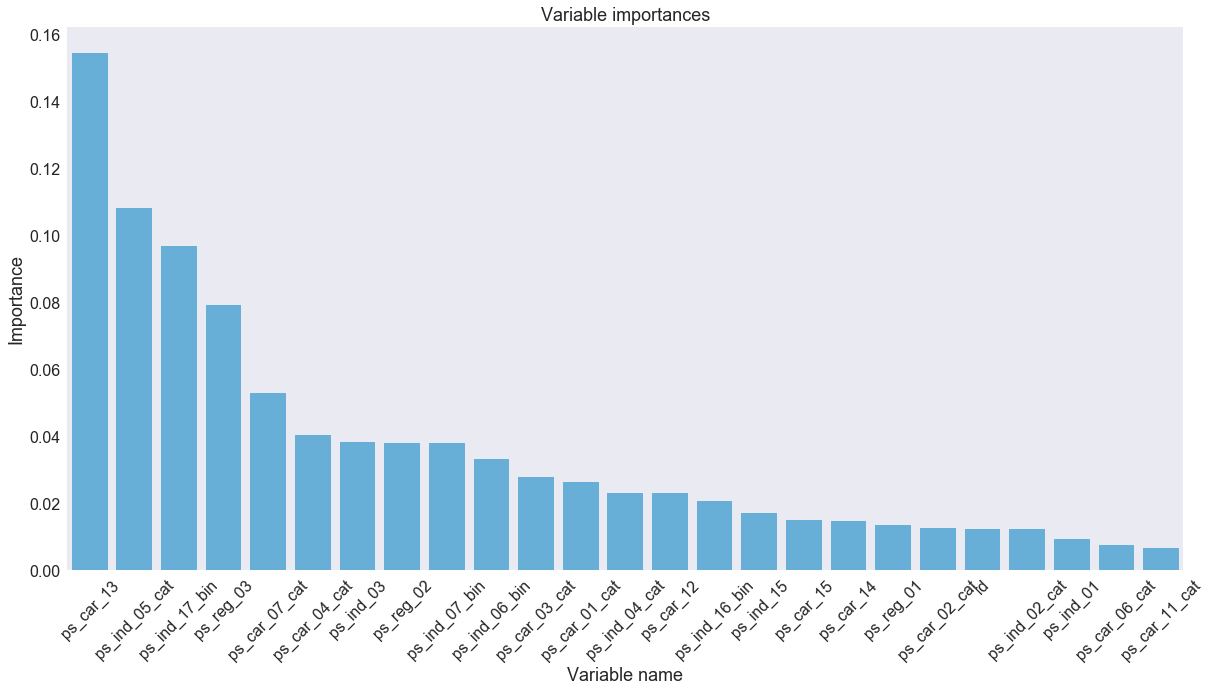

In [111]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)
g=sns.barplot(data=feature_importance,x="feature",y="importance",ax=ax,color=default_color,)
for item in g.get_xticklabels():
    item.set_rotation(45)
ax.set(xlabel='Variable name', ylabel='Importance',title="Variable importances")

## Cross Val function and Other Models

In [125]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [131]:
def cross_val_model(X, y, model, n_splits=3):
   
    X = np.array(X)
    y = np.array(y)

    folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42).split(X, y))

    cross_score_mean = 0.0

    t0 = time()
    
    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]
        y_holdout = y[test_idx]

        print ("Fit %s fold %d" % (str(model).split('(')[0], j+1))
        model.fit(X_train, y_train)
        cross_score = cross_val_score(model, X_holdout, y_holdout, cv=3, scoring='roc_auc')
        print("    cross_score: %.5f (%.5f)" % (cross_score.mean(), cross_score.mean()*2-1)) 
        print("    [%10d secs elapsed]: cross_score: %.5f (%.5f)" % (time()-t0, cross_score.mean(), cross_score.mean()*2-1)) 
        cross_score_mean += cross_score.mean()
        
    cross_score_mean /= n_splits
    print("cross_score_mean: %.5f (%.5f)" % (cross_score_mean, cross_score_mean*2-1))

#### Cross Val - Random Forest

In [132]:
conf_rf_model = {
    'n_estimators': 200,
    'max_depth': 6,
    'min_samples_split': 70,
    'min_samples_leaf': 30,
    'n_jobs': -1,
}

In [133]:
rf_model = RandomForestClassifier(**conf_rf_model)

In [134]:
cross_val_model(train, y, rf_model)

Fit RandomForestClassifier fold 1
    cross_score: 0.62207 (0.24413)
    [       111 secs elapsed]: cross_score: 0.62207 (0.24413)
Fit RandomForestClassifier fold 2
    cross_score: 0.62434 (0.24868)
    [       217 secs elapsed]: cross_score: 0.62434 (0.24868)
Fit RandomForestClassifier fold 3
    cross_score: 0.59388 (0.18777)
    [       325 secs elapsed]: cross_score: 0.59388 (0.18777)
cross_score_mean: 0.61343 (0.22686)


#### Cross Val - XGBoost

In [153]:
conf_xgb_model = {
    'n_estimators': 200,
    'max_depth': 4,
    'objective': 'binary:logistic',
    'learning_rate': 0.02,
    'subsample': 0.9, 
    'colsample_bytree': 0.6,
    'reg_alpha': 6e-05,
    'reg_lambda': 7e-06,
    'min_child_weight': 100
}

In [154]:
xgb_model = XGBClassifier(**conf_xgb_model)

In [155]:
cross_val_model(train, y, xgb_model)

Fit XGBClassifier fold 1
    cross_score: 0.62450 (0.24900)
    [       142 secs elapsed]: cross_score: 0.62450 (0.24900)
Fit XGBClassifier fold 2
    cross_score: 0.62659 (0.25318)
    [       280 secs elapsed]: cross_score: 0.62659 (0.25318)
Fit XGBClassifier fold 3
    cross_score: 0.63227 (0.26454)
    [       409 secs elapsed]: cross_score: 0.63227 (0.26454)
cross_score_mean: 0.62779 (0.25557)


In [150]:
# parameters from https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283/code
conf_xgb_model_2 = {
    'n_estimators': 200,
    'max_depth': 4,
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 1,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'nthread': 2,
    'min_child_weight': 100
}

In [151]:
xgb_model_2 = XGBClassifier(**conf_xgb_model_2)

In [152]:
cross_val_model(train, y, xgb_model_2)

Fit XGBClassifier fold 1
    cross_score: 0.62967 (0.25933)
    [       186 secs elapsed]: cross_score: 0.62967 (0.25933)
Fit XGBClassifier fold 2
    cross_score: 0.62987 (0.25974)
    [       381 secs elapsed]: cross_score: 0.62987 (0.25974)
Fit XGBClassifier fold 3
    cross_score: 0.63328 (0.26655)
    [       565 secs elapsed]: cross_score: 0.63328 (0.26655)
cross_score_mean: 0.63094 (0.26188)


#### Cross Val - LGBM

In [220]:
conf_lgb_model = {
    'boosting_type': 'gbdt',
    'n_estimators': 200,
    'max_depth': 5,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'sub_feature': 0.8,
    'num_leaves': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 3,
}

In [221]:
lgb_model = LGBMClassifier(**conf_lgb_model)

In [222]:
cross_val_model(train, y, lgb_model)

Fit LGBMClassifier fold 1
    cross_score: 0.62589 (0.25178)
    [        26 secs elapsed]: cross_score: 0.62589 (0.25178)
Fit LGBMClassifier fold 2
    cross_score: 0.62400 (0.24800)
    [        53 secs elapsed]: cross_score: 0.62400 (0.24800)
Fit LGBMClassifier fold 3
    cross_score: 0.62549 (0.25099)
    [        83 secs elapsed]: cross_score: 0.62549 (0.25099)
cross_score_mean: 0.62513 (0.25025)


In [202]:
conf_lgb_model = {
    'boosting_type': 'gbdt',
    'n_estimators': 200,
    'max_depth': 4,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'sub_feature': 0.8,
    'num_leaves': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 3,
}

In [203]:
lgb_model = LGBMClassifier(**conf_lgb_model)

In [204]:
cross_val_model(train, y, lgb_model)

Fit LGBMClassifier fold 1
    cross_score: 0.62807 (0.25614)
    [        27 secs elapsed]: cross_score: 0.62807 (0.25614)
Fit LGBMClassifier fold 2
    cross_score: 0.62658 (0.25317)
    [        59 secs elapsed]: cross_score: 0.62658 (0.25317)
Fit LGBMClassifier fold 3
    cross_score: 0.62890 (0.25780)
    [        94 secs elapsed]: cross_score: 0.62890 (0.25780)
cross_score_mean: 0.62785 (0.25570)


In [187]:
conf_lgb_model = {
    'boosting_type': 'gbdt',
    'n_estimators': 100,
    'max_depth': 10,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'sub_feature': 0.8,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
}

In [188]:
lgb_model = LGBMClassifier(**conf_lgb_model)

In [189]:
cross_val_model(train, y, lgb_model)

Fit LGBMClassifier fold 1
    cross_score: 0.62710 (0.25420)
    [        16 secs elapsed]: cross_score: 0.62710 (0.25420)
Fit LGBMClassifier fold 2
    cross_score: 0.62743 (0.25485)
    [        33 secs elapsed]: cross_score: 0.62743 (0.25485)
Fit LGBMClassifier fold 3
    cross_score: 0.62621 (0.25241)
    [        49 secs elapsed]: cross_score: 0.62621 (0.25241)
cross_score_mean: 0.62691 (0.25382)


In [163]:
conf_lgb_model = {
    'boosting_type': 'gbdt',
    'n_estimators': 100,
    'max_depth': 10,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'sub_feature': 0.5,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}

In [164]:
lgb_model = LGBMClassifier(**conf_lgb_model)

In [165]:
cross_val_model(train, y, lgb_model)

Fit LGBMClassifier fold 1
    cross_score: 0.62528 (0.25056)
    [        18 secs elapsed]: cross_score: 0.62528 (0.25056)
Fit LGBMClassifier fold 2
    cross_score: 0.62665 (0.25331)
    [        37 secs elapsed]: cross_score: 0.62665 (0.25331)
Fit LGBMClassifier fold 3
    cross_score: 0.62443 (0.24885)
    [        57 secs elapsed]: cross_score: 0.62443 (0.24885)
cross_score_mean: 0.62545 (0.25091)


In [161]:
lgb_model = LGBMClassifier(**conf_lgb_model)

In [162]:
#
#conf_lgb_model = {
#    'boosting_type': 'gbdt',
#    'n_estimators': 200,
#    'max_depth': 10,
#    'objective': 'binary',
#    'metric': 'binary_logloss',
#    'learning_rate': 0.05,
#    'sub_feature': 0.5,
#    'num_leaves': 31,
#    'feature_fraction': 0.9,
#    'bagging_fraction': 0.8,
#    'bagging_freq': 5,
#}
cross_val_model(train, y, lgb_model)

Fit LGBMClassifier fold 1
    cross_score: 0.62055 (0.24109)
    [        32 secs elapsed]: cross_score: 0.62055 (0.24109)
Fit LGBMClassifier fold 2
    cross_score: 0.62686 (0.25372)
    [        65 secs elapsed]: cross_score: 0.62686 (0.25372)
Fit LGBMClassifier fold 3
    cross_score: 0.62413 (0.24826)
    [        97 secs elapsed]: cross_score: 0.62413 (0.24826)
cross_score_mean: 0.62384 (0.24769)


In [159]:
# OLD params
#conf_lgb_model = {
#    'boosting_type': 'gbdt',
#    'n_estimators': 200,
#    'max_depth': 10,
#    'objective': 'binary',
#    'metric': 'binary_logloss',
#    'learning_rate': 0.1,
#    'sub_feature': 0.5,
#    'num_leaves': 50,
#    'min_data': 50,
#}
cross_val_model(train, y, lgb_model)

Fit LGBMClassifier fold 1
    cross_score: 0.60448 (0.20897)
    [        31 secs elapsed]: cross_score: 0.60448 (0.20897)
Fit LGBMClassifier fold 2
    cross_score: 0.59937 (0.19874)
    [        62 secs elapsed]: cross_score: 0.59937 (0.19874)
Fit LGBMClassifier fold 3
    cross_score: 0.61164 (0.22328)
    [        94 secs elapsed]: cross_score: 0.61164 (0.22328)
cross_score_mean: 0.60517 (0.21033)


In [142]:
# OLD Parameters
cross_val_model(train, y, lgb_model)

Fit LGBMClassifier fold 1
    cross_score: 0.62147 (0.24295)
    [        17 secs elapsed]: cross_score: 0.62147 (0.24295)
Fit LGBMClassifier fold 2
    cross_score: 0.62225 (0.24451)
    [        33 secs elapsed]: cross_score: 0.62225 (0.24451)
Fit LGBMClassifier fold 3
    cross_score: 0.62333 (0.24666)
    [        50 secs elapsed]: cross_score: 0.62333 (0.24666)
cross_score_mean: 0.62235 (0.24470)


## Feature Engineering & Selection

In [223]:
# Selected features from https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283/code
selected_features = [
    "ps_car_13",  #            : 1571.65 / shadow  609.23
    "ps_reg_03",  #            : 1408.42 / shadow  511.15
    "ps_ind_05_cat",  #        : 1387.87 / shadow   84.72
    "ps_ind_03",  #            : 1219.47 / shadow  230.55
    "ps_ind_15",  #            :  922.18 / shadow  242.00
    "ps_reg_02",  #            :  920.65 / shadow  267.50
    "ps_car_14",  #            :  798.48 / shadow  549.58
    "ps_car_12",  #            :  731.93 / shadow  293.62
    "ps_car_01_cat",  #        :  698.07 / shadow  178.72
    "ps_car_07_cat",  #        :  694.53 / shadow   36.35
    "ps_ind_17_bin",  #        :  620.77 / shadow   23.15
    "ps_car_03_cat",  #        :  611.73 / shadow   50.67
    "ps_reg_01",  #            :  598.60 / shadow  178.57
    "ps_car_15",  #            :  593.35 / shadow  226.43
    "ps_ind_01",  #            :  547.32 / shadow  154.58
    "ps_ind_16_bin",  #        :  475.37 / shadow   34.17
    "ps_ind_07_bin",  #        :  435.28 / shadow   28.92
    "ps_car_06_cat",  #        :  398.02 / shadow  212.43
    "ps_car_04_cat",  #        :  376.87 / shadow   76.98
    "ps_ind_06_bin",  #        :  370.97 / shadow   36.13
    "ps_car_09_cat",  #        :  214.12 / shadow   81.38
    "ps_car_02_cat",  #        :  203.03 / shadow   26.67
    "ps_ind_02_cat",  #        :  189.47 / shadow   65.68
    "ps_car_11",  #            :  173.28 / shadow   76.45
    "ps_car_05_cat",  #        :  172.75 / shadow   62.92
    "ps_calc_09",  #           :  169.13 / shadow  129.72
    "ps_calc_05",  #           :  148.83 / shadow  120.68
    "ps_ind_08_bin",  #        :  140.73 / shadow   27.63
    "ps_car_08_cat",  #        :  120.87 / shadow   28.82
    "ps_ind_09_bin",  #        :  113.92 / shadow   27.05
    "ps_ind_04_cat",  #        :  107.27 / shadow   37.43
    "ps_ind_18_bin",  #        :   77.42 / shadow   25.97
    "ps_ind_12_bin",  #        :   39.67 / shadow   15.52
    "ps_ind_14",  #            :   37.37 / shadow   16.65
    "ps_car_11_cat" # Very nice spot from Tilii : https://www.kaggle.com/tilii7
]

### Adding Combs

In [ ]:
# add combinations from https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283/code
combs = [
    ('ps_reg_01', 'ps_car_02_cat'),  
    ('ps_reg_01', 'ps_car_04_cat'),
]
start = time.time()
for n_c, (f1, f2) in enumerate(combs):
    name1 = f1 + "_plus_" + f2
    print('current feature %60s %4d in %5.1f' % (name1, n_c + 1, (time.time() - start) / 60), end='')
    print('\r' * 75, end='')
    train[name1] = train[f1].apply(lambda x: str(x)) + "_" + train[f2].apply(lambda x: str(x))
    test[name1] = test[f1].apply(lambda x: str(x)) + "_" + test[f2].apply(lambda x: str(x))
    # Label Encode
    lbl = LabelEncoder()
    lbl.fit(list(train[name1].values) + list(test[name1].values))
    trn_df[name1] = lbl.transform(list(train[name1].values))
    test[name1] = lbl.transform(list(test[name1].values))

In [ ]:
new_features = [f1 + '_plus_' + f2 for (f1, f2) in combs]
selected_features.append(new_features)
new_features

### Target Encoding

In [ ]:
f_cats = [f for f in trn_df.columns if "_cat" in f]

for f in f_cats:
    trn_df[f + "_avg"], sub_df[f + "_avg"] = target_encode(trn_series=trn_df[f],
                                         tst_series=sub_df[f],
                                         target=target,
                                         min_samples_leaf=200,
                                         smoothing=10,
                                         noise_level=0)

### reconstructing ps_reg_03

In [ ]:
### from Pascal's (https://www.kaggle.com/pnagel/reconstruction-of-ps-reg-03)
def recon(reg):
    integer = int(np.round((40*reg)**2)) 
    for a in range(32):
        if (integer - a) % 31 == 0:
            A = a
    M = (integer - A)//31
    return A, M

train['ps_reg_A'] = train['ps_reg_03'].apply(lambda x: recon(x)[0] )
train['ps_reg_M'] = train['ps_reg_03'].apply(lambda x: recon(x)[1])
train['ps_reg_A'].replace(19, np.NaN, inplace=True)
train['ps_reg_M'].replace(51, np.NaN, inplace=True)

test['ps_reg_A'] = test['ps_reg_03'].apply(lambda x: recon(x)[0])
test['ps_reg_M'] = test['ps_reg_03'].apply(lambda x: recon(x)[1])
test['ps_reg_A'].replace(19, np.NaN, inplace=True)
test['ps_reg_M'].replace(51, np.NaN, inplace=True)

In [ ]:
columns_fe = list(columns_original - set(train.columns))
columns_fe

### Ecoding Variables

In [120]:
one_hot = {c: len(list(train[c].unique())) for c in train.columns}
one_hot

{'id': 595212,
 'ps_calc_01': 10,
 'ps_calc_02': 10,
 'ps_calc_03': 10,
 'ps_calc_04': 6,
 'ps_calc_05': 7,
 'ps_calc_06': 11,
 'ps_calc_07': 10,
 'ps_calc_08': 11,
 'ps_calc_09': 8,
 'ps_calc_10': 26,
 'ps_calc_11': 20,
 'ps_calc_12': 11,
 'ps_calc_13': 14,
 'ps_calc_14': 24,
 'ps_calc_15_bin': 2,
 'ps_calc_16_bin': 2,
 'ps_calc_17_bin': 2,
 'ps_calc_18_bin': 2,
 'ps_calc_19_bin': 2,
 'ps_calc_20_bin': 2,
 'ps_car_01_cat': 13,
 'ps_car_02_cat': 3,
 'ps_car_03_cat': 3,
 'ps_car_04_cat': 10,
 'ps_car_05_cat': 3,
 'ps_car_06_cat': 18,
 'ps_car_07_cat': 3,
 'ps_car_08_cat': 2,
 'ps_car_09_cat': 6,
 'ps_car_10_cat': 3,
 'ps_car_11': 5,
 'ps_car_11_cat': 104,
 'ps_car_12': 184,
 'ps_car_13': 70482,
 'ps_car_14': 850,
 'ps_car_15': 15,
 'ps_ind_01': 8,
 'ps_ind_02_cat': 5,
 'ps_ind_03': 12,
 'ps_ind_04_cat': 3,
 'ps_ind_05_cat': 8,
 'ps_ind_06_bin': 2,
 'ps_ind_07_bin': 2,
 'ps_ind_08_bin': 2,
 'ps_ind_09_bin': 2,
 'ps_ind_10_bin': 2,
 'ps_ind_11_bin': 2,
 'ps_ind_12_bin': 2,
 'ps_ind_13_bin

In [ ]:
def OHE_by_unique(train, one_hot, limit):
    used_colums = []
    
    #ONE-HOT enconde features with more than 2 and less than 'limit' unique values
    df = train.copy()
    for c in one_hot:
        if one_hot[c] > 2 and one_hot[c] < limit:
            used_colums.append(c)
            for val in one_hot[c]:
                df[c+'_oh_' + str(val)] = (df[c].values == val).astype(np.int)
    print('used columns: %s' % used_colums)
    return df

In [ ]:
train = OHE_by_unique(train, one_hot, 7)

In [ ]:
test = OHE_by_unique(test, one_hot, 7)